<a href="https://colab.research.google.com/github/muzammilkhattri/HacktoberFest-Hackathon/blob/main/Issue%20%233/QuarkAI/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import math

# Dataset Creation

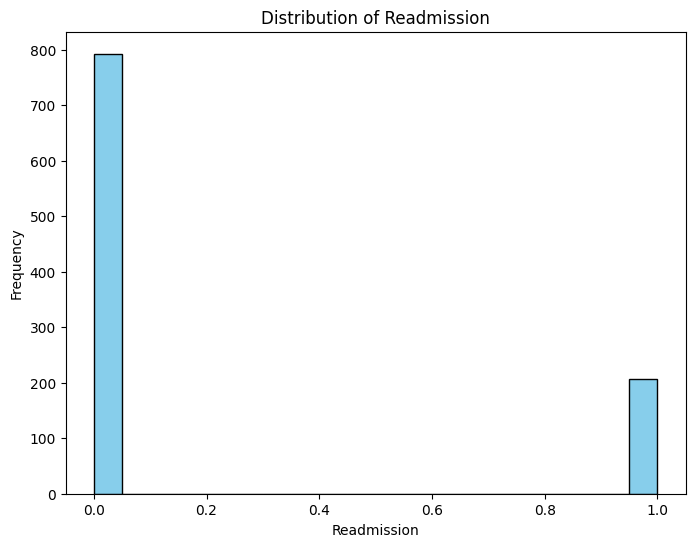

In [17]:
np.random.seed(42)

# Number of patients
num_patients = 1000

# demographics data
ages = np.random.randint(18, 90, size=num_patients)
genders = np.random.choice(['Male', 'Female'], size=num_patients)
ethnicity = np.random.choice(['White', 'Black', 'Asian', 'Hispanic'], size=num_patients)

diagnosis_codes = np.random.choice(['ICD_A', 'ICD_B', 'ICD_C', 'ICD_D'], size=num_patients)

blood_pressure_systolic = np.random.normal(120, 20, num_patients)
blood_pressure_diastolic = np.random.normal(80, 10, num_patients)
heart_rate = np.random.normal(75, 10, num_patients)
oxygen_saturation = np.random.normal(95, 3, num_patients)

blood_sugar = np.random.normal(110, 20, num_patients)
cholesterol = np.random.normal(200, 50, num_patients)
creatinine = np.random.normal(1.0, 0.3, num_patients)

treatment_history = np.random.randint(0, 2, size=num_patients)

sudden_bp_drop = np.random.choice([0, 1], size=num_patients, p=[0.8, 0.2])

readmission = np.random.choice([0, 1], size=num_patients, p=[0.8, 0.2])

data = {
    'Age': ages,
    'Gender': genders,
    'Ethnicity': ethnicity,
    'Diagnosis_Code': diagnosis_codes,
    'BP_Systolic': blood_pressure_systolic,
    'BP_Diastolic': blood_pressure_diastolic,
    'Heart_Rate': heart_rate,
    'Oxygen_Saturation': oxygen_saturation,
    'Blood_Sugar': blood_sugar,
    'Cholesterol': cholesterol,
    'Creatinine': creatinine,
    'Treatment_History': treatment_history,
    'Sudden_BP_Drop': sudden_bp_drop,
    'Readmission': readmission
}

df = pd.DataFrame(data)

df.to_csv('icu_readmission_data.csv', index=False)

# Plot readmission
plt.figure(figsize=(8, 6))
plt.hist(df['Readmission'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Readmission')
plt.ylabel('Frequency')
plt.title('Distribution of Readmission')
plt.show()



# Preprocessing

In [35]:
# Load your dataset (replace 'icu_readmission_data.csv' with your actual dataset)
df = pd.read_csv('icu_readmission_data.csv')

# 1. Handling Missing Data
numeric_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Imputers for missing data
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute numeric and categorical columns
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# 2. Handling Outliers using Z-score method
z_scores = np.abs(stats.zscore(df[numeric_features]))
df = df[(z_scores < 3).all(axis=1)]

# 3. Encoding Categorical Variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = pd.DataFrame(encoder.fit_transform(df[categorical_features]),
                               columns=encoder.get_feature_names_out(categorical_features))

# Concatenate the encoded columns with the original dataframe and drop original categorical columns
df = pd.concat([df, encoded_columns], axis=1)
df = df.drop(categorical_features, axis=1)

# 4. Check and handle missing values in the target column ('Readmission')
if df['Readmission'].isnull().sum() > 0:
    df = df.dropna(subset=['Readmission'])

X = df.drop(columns='Readmission')
y = df['Readmission']


# y = np.where(y > 0.5, 1, 0)


X = X.replace({np.nan: 0})

# 6. Apply SMOTE to balance classes only if there are no missing values
if X.isnull().sum().sum() == 0:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
else:
    print("There are still missing values in the features.")


# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
